In [97]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set working directory
import os
current_dir = os.getcwd()
os.chdir(current_dir.replace('\code', '\data'))

<>:9: DeprecationWarning: invalid escape sequence '\c'
<>:9: DeprecationWarning: invalid escape sequence '\d'
<>:9: DeprecationWarning: invalid escape sequence '\c'
<>:9: DeprecationWarning: invalid escape sequence '\d'
C:\Users\Jack\AppData\Local\Temp\ipykernel_2812\2141329615.py:9: DeprecationWarning: invalid escape sequence '\c'
  os.chdir(current_dir.replace('\code', '\data'))
C:\Users\Jack\AppData\Local\Temp\ipykernel_2812\2141329615.py:9: DeprecationWarning: invalid escape sequence '\d'
  os.chdir(current_dir.replace('\code', '\data'))


In [98]:
# Load data
gross_passing = pd.read_csv('gross_pfr_passing.csv')
gross_rushing = pd.read_csv('gross_pfr_rushing.csv')
gross_receiving = pd.read_csv('gross_pfr_receiving.csv')
gross_team_offense = pd.read_csv('gross_pfr_team_offense.csv')
gross_combine = pd.read_csv('gross_pfr_combine.csv')
gross_salary = pd.read_csv('gross_pfr_salary.csv')

# Feature Engineering

- make a new column that tells whether or not the player's future team is different than their last team.
- create a basket analysis of teams' position ranks.
- use models to fidn the expected value of the most important predictors like yards and tds.

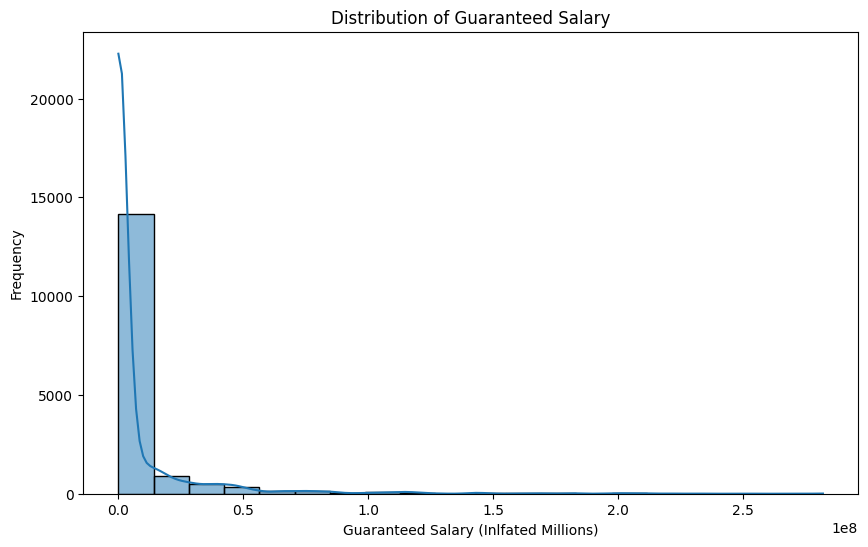

In [99]:
# Salary data
gross_salary = gross_salary[['Player', 'Contract_Years', 'Inflated_Guaranteed']]

plt.figure(figsize=(10, 6))
sns.histplot(gross_salary['Inflated_Guaranteed'], bins=20, kde=True)
plt.title('Distribution of Guaranteed Salary')
plt.xlabel('Guaranteed Salary (Inlfated Millions)')
plt.ylabel('Frequency')
plt.show()

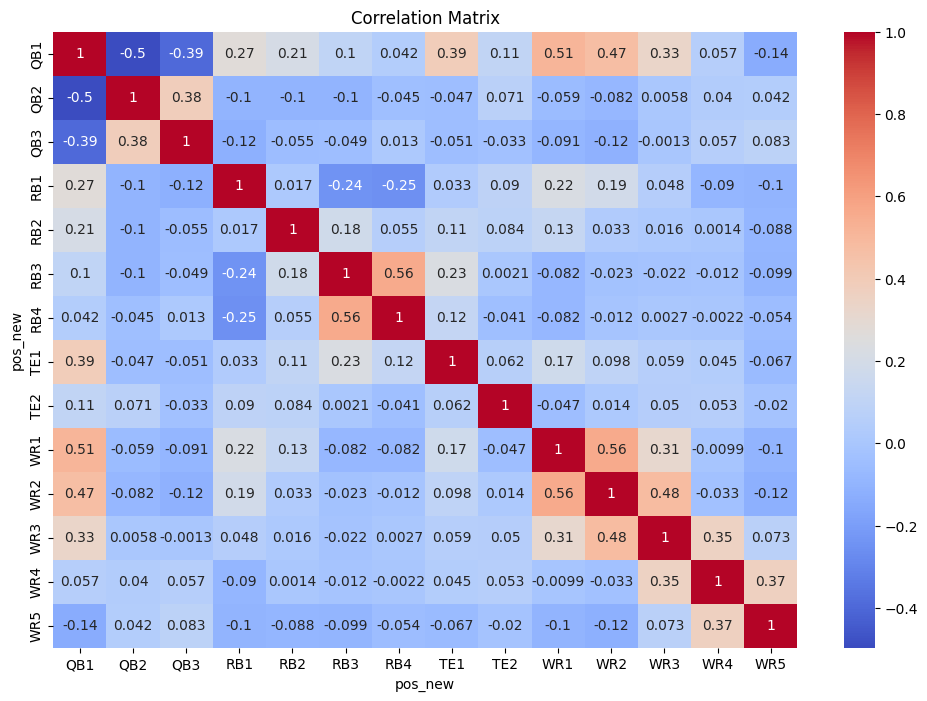

In [100]:
# Team Distribution
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

# Aggregate data
df_pass = gross_passing[['Passing_Points', 'Pos', 'Year', 'Player', 'Tm']]
df_rush = gross_rushing[['Rushing_Points', 'Pos', 'Year', 'Player', 'Tm']]
df_rec = gross_receiving[['Receiving_Points', 'Pos', 'Year', 'Player', 'Tm']]
df = df_pass.merge(df_rush, on=['Pos', 'Year', 'Player', 'Tm'], how='outer')
df = df.merge(df_rec, on=['Pos', 'Year', 'Player', 'Tm'], how='outer')
df = df.fillna(0)
df['Fantasy_Points'] = df['Passing_Points'] + df['Rushing_Points'] + df['Receiving_Points']
df = df.drop(['Passing_Points', 'Rushing_Points', 'Receiving_Points', 'Player'], axis=1)
df = df[df['Pos'].isin(['QB', 'RB', 'WR', 'TE'])]
df = df[df['Fantasy_Points'] >= 10]
df = df.reset_index(drop=True)
# New column: pos_new which is the position rank per team
df['pos_rank'] = df.groupby(['Tm', 'Year', 'Pos'])['Fantasy_Points'].rank(ascending=False, method='first')
df['pos_rank'] = df['pos_rank'].astype(int)
df['pos_new'] = df['Pos'] + df['pos_rank'].astype(str)
# Pivot df on Tm, Year so that the columns are the positions and the values are the individual fantasy points
df = df.pivot_table(index=['Tm', 'Year'], columns='pos_new', values='Fantasy_Points').reset_index()
# Drop columns with less than 10% of the data
df = df.dropna(thresh=0.1*len(df), axis=1)
df = df.fillna(0)
df = df.sort_values(by='QB1', ascending=False)
team_distribution = df.copy()
# Correlation matrix
corr = df.drop(columns=['Tm', 'Year']).corr()
# Plot
plt.figure(figsize=(12, 8))
sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [101]:
# Career Clustering
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

def career_averaging(df, target_column):
    # Prepare the data
    df = df[['Player', target_column, 'Year']]

    # Aggregate data to ensure unique Player-Year combinations
    df = df.groupby(['Player', 'Year']).agg({target_column: 'mean'}).reset_index()

    # Pivot the data on Year
    df_pivot = df.pivot(index='Player', columns='Year', values=target_column).reset_index()

    # Save players
    players = df_pivot['Player']
    df_pivot = df_pivot.drop(columns=['Player'])

    # For every column, average the current year and the previous years
    player_career = pd.DataFrame()
    for i in range(1, df_pivot.shape[1] + 1):
        player_career[i] = df_pivot.iloc[:, :i].mean(axis=1)

    # Rename each column to the year
    first_year_column = df_pivot.columns[0]
    player_career.columns = [str(i) for i in range(first_year_column+1, first_year_column + df_pivot.shape[1]+1)]
    player_career['Player'] = players

    # Melth the data
    player_career = player_career.melt(id_vars='Player', var_name='Year', value_name=target_column)

    # Convert Year to numeric
    player_career['Year'] = player_career['Year'].astype(int)

    # Add 'Career_' to the target column
    player_career = player_career.rename(columns={target_column: 'Career_' + target_column})

    return player_career

passing_career = career_averaging(gross_passing, 'Passing_Points')
rushing_career = career_averaging(gross_rushing, 'Rushing_Points')
receiving_career = career_averaging(gross_receiving, 'Receiving_Points')

receiving_career.head()

,Player,Year,Career_Receiving_Points
0,A.J. Brown,2013,NaN
1,A.J. Derby,2013,NaN
2,A.J. Green,2013,249.5
3,AJ Dillon,2013,NaN
4,Aaron Dobson,2013,NaN


In [102]:
# Team Relative Stats
def team_relative(df, metric='_Pass'):
    # Locate data
    team_df = gross_team_offense[['Tm', 'Year', 'Yds'+metric, 'TD'+metric, '1stD'+metric]]
    df = df[['Player', 'Tm', 'Year', 'TD', 'Yds', '1D']]

    # Merge data
    df = df.merge(team_df, on=['Tm', 'Year'], how='left')

    # Calculate relative stats
    df['Relative_TD'] = df['TD'] / df['TD'+metric]
    df['Relative_Yds'] = df['Yds'] / df['Yds'+metric]
    df['Relative_1D'] = df['1D'] / df['1stD'+metric]

    # Drop unnecessary columns
    df = df.drop(columns=['Tm', 'TD', 'Yds', '1D', 'TD'+metric, 'Yds'+metric, '1stD'+metric])

    return df

passing_relative = team_relative(gross_passing, '_Pass')
rushing_relative = team_relative(gross_rushing, '_Rush')
receiving_relative = team_relative(gross_receiving, '_Pass')

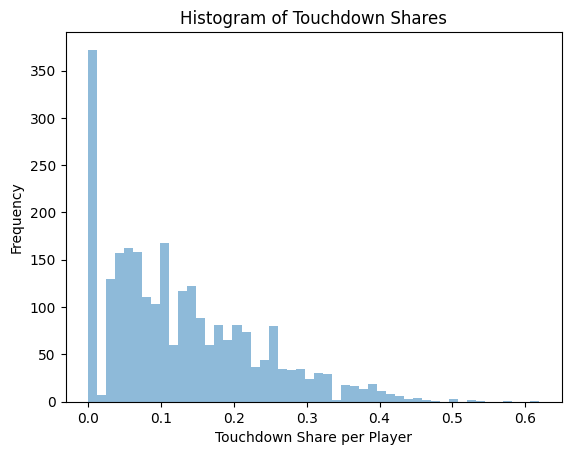

In [103]:
# Histogram of Relative Stats
plt.hist(receiving_relative['Relative_TD'], bins=50, alpha=0.5, label='TD')
plt.ylabel('Frequency')
plt.xlabel('Touchdown Share per Player')
plt.title('Histogram of Touchdown Shares')
plt.show()

In [104]:
# Merge career stats
gross_passing = gross_passing.merge(passing_career, on=['Player', 'Year'], how='left')
gross_rushing = gross_rushing.merge(rushing_career, on=['Player', 'Year'], how='left')
gross_receiving = gross_receiving.merge(receiving_career, on=['Player', 'Year'], how='left')

# Merge relative stats
gross_passing = gross_passing.merge(passing_relative, on=['Player', 'Year'], how='left')
gross_rushing = gross_rushing.merge(rushing_relative, on=['Player', 'Year'], how='left')
gross_receiving = gross_receiving.merge(receiving_relative, on=['Player', 'Year'], how='left')

# Merge team distribution
gross_team_offense = gross_team_offense.merge(team_distribution, on=['Tm', 'Year'], how='left')

# Merge salary data
gross_passing = gross_passing.merge(gross_salary, left_on=['Player', 'Year'], right_on=['Player', 'Contract_Years'], how='left')
gross_rushing = gross_rushing.merge(gross_salary, left_on=['Player', 'Year'], right_on=['Player', 'Contract_Years'], how='left')
gross_receiving = gross_receiving.merge(gross_salary, left_on=['Player', 'Year'], right_on=['Player', 'Contract_Years'], how='left')

# Feature Selection

In [105]:
# Test function
def transform_x_y(data, columns_to_drop=['Player', 'Tm', 'Pos', 'Year', 'Age'], target_column='Passing_Points'):
    # Create the future target column
    future = data[['Player', 'Year', target_column]].copy()
    future['Year'] = future['Year'] - 1
    future.columns = ['Player', 'Year', 'Future_' + target_column]

    # Merge the future target column with the data
    data = pd.merge(data, future, on=['Player', 'Year'], how='left')

    # Clean the data
    data = data.dropna(subset=['Future_' + target_column]).reset_index(drop=True)
    data = data.fillna(-1)
    X = data.drop(columns=columns_to_drop + ['Future_' + target_column])
    y = data['Future_' + target_column]

    return X, y

In [106]:
# Function that takes in x and y and performs an xbgoost with cv that returns feature importance
def feature_selection(X, y, n_splits=2, random_state=123):
    import xgboost as xgb
    from sklearn.model_selection import cross_val_score, KFold
    # Initialize the model
    model = xgb.XGBRegressor(objective='reg:squarederror', max_depth=10, eta=1, 
                             n_estimators=30, random_state=random_state, learning_rate=0.2)

    # Perform cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    scores = cross_val_score(model, X, y, cv=kfold, scoring='neg_mean_squared_error')

    # Fit the model on the entire dataset
    model.fit(X, y)

    # Get the importance measures
    gain = model.get_booster().get_score(importance_type='gain')
    cover = model.get_booster().get_score(importance_type='cover')

    # Merge the measures
    importance = pd.DataFrame({'Feature': list(gain.keys()), 'Gain': list(gain.values()), 'Cover': list(cover.values())})

    # Fill NaN values with 0
    importance = importance.fillna(0)

    # Normalize the importance scores
    importance['Gain'] = importance['Gain'] / importance['Gain'].sum()
    importance['Cover'] = importance['Cover'] / importance['Cover'].sum()

    # Compute the composite score
    importance['Composite_Importance'] = (importance['Gain'] + importance['Cover']) / 2

    # Sort by composite importance
    importance = importance.sort_values(by='Composite_Importance', ascending=False)

    return importance, scores

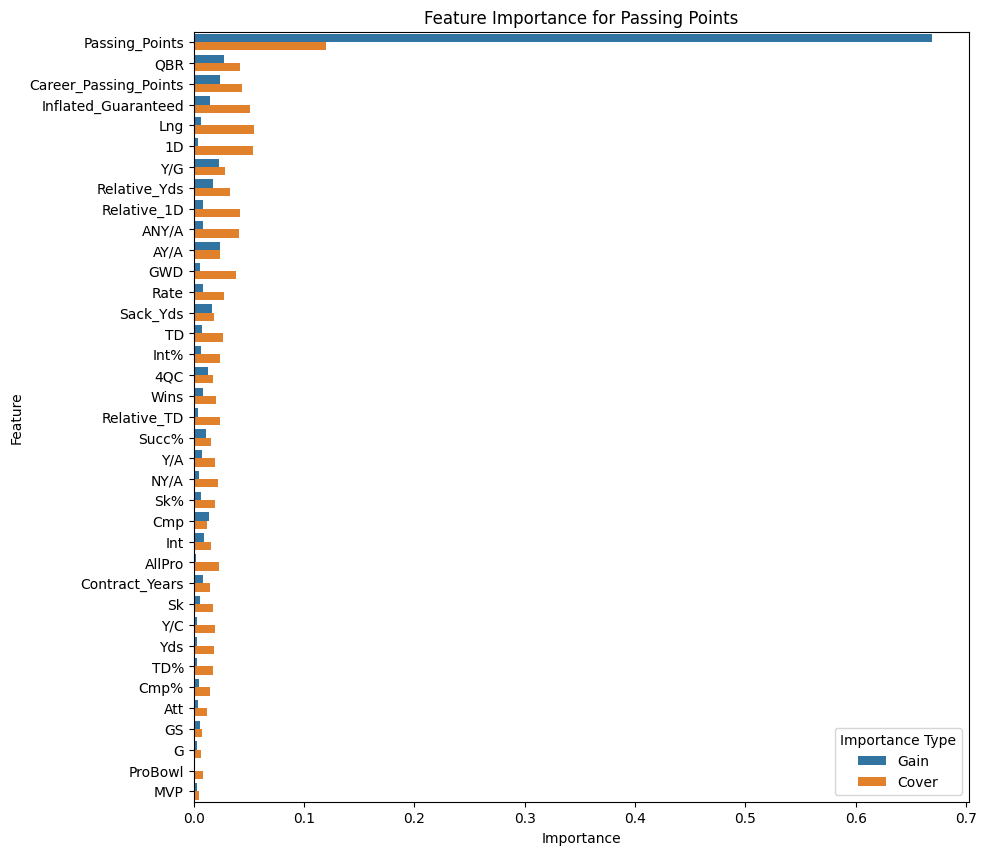

In [107]:
# Passing feature selection
X, y = transform_x_y(gross_passing, target_column='Passing_Points')

importance, scores = feature_selection(X, y)

# Reshape the DataFrame to long format
importance_long = pd.melt(importance, id_vars=['Feature'], value_vars=['Gain', 'Cover'],
                          var_name='Importance_Type', value_name='Importance')

# Plot the data
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', hue='Importance_Type', data=importance_long)
plt.title('Feature Importance for Passing Points')
plt.legend(title='Importance Type')
plt.show()

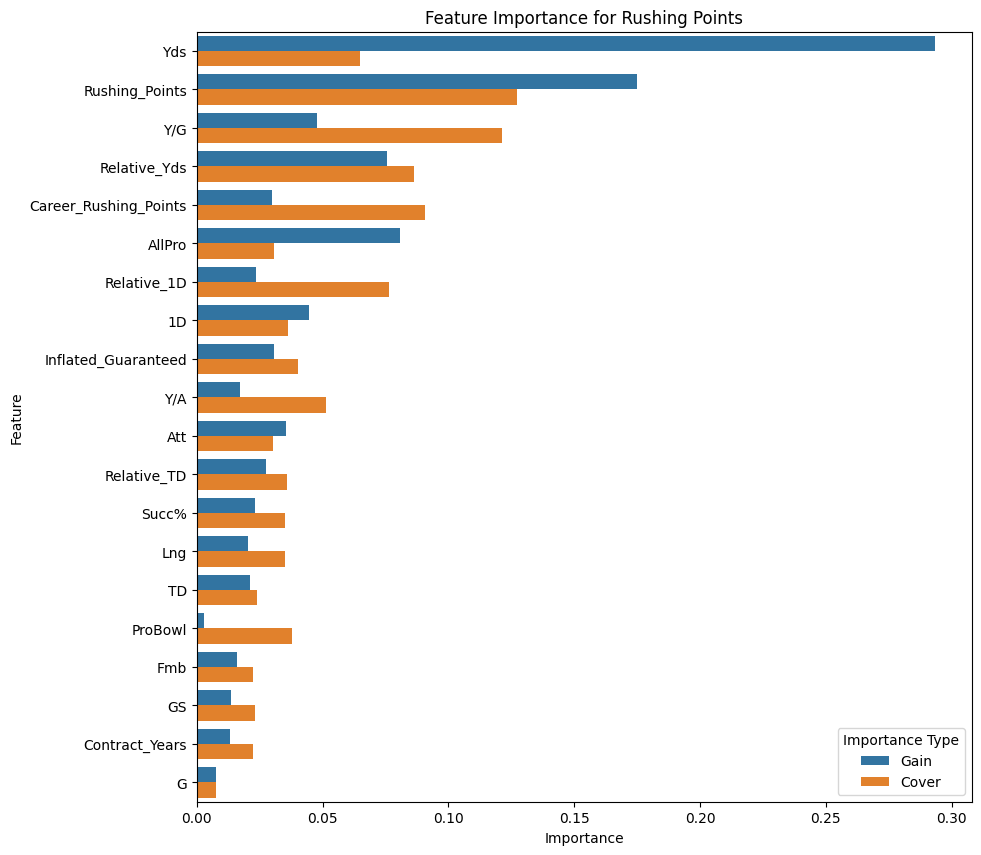

In [108]:
# Rushing feature selection
X, y = transform_x_y(gross_rushing, target_column='Rushing_Points')

importance, scores = feature_selection(X, y)

# Reshape the DataFrame to long format
importance_long = pd.melt(importance, id_vars=['Feature'], value_vars=['Gain', 'Cover'],
                          var_name='Importance_Type', value_name='Importance')

# Plot the data
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', hue='Importance_Type', data=importance_long)
plt.title('Feature Importance for Rushing Points')
plt.legend(title='Importance Type')
plt.show()

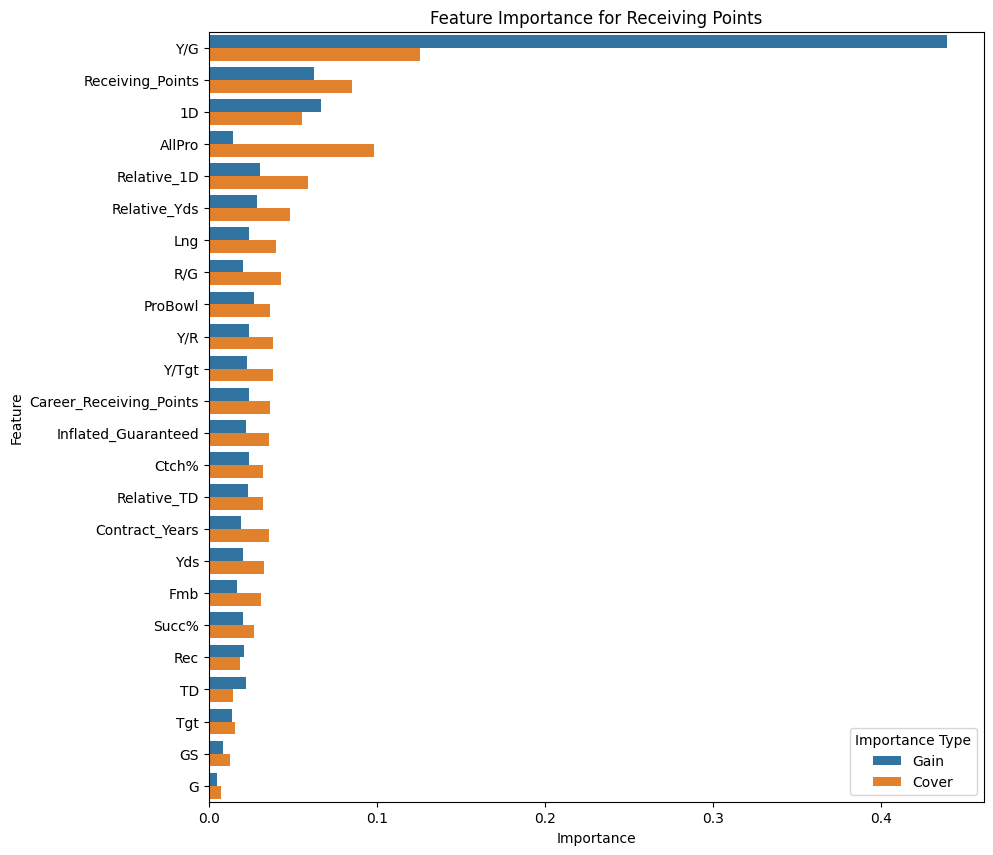

In [109]:
# Receiving feature selection
X, y = transform_x_y(gross_receiving, target_column='Receiving_Points')

importance, scores = feature_selection(X, y)

# Reshape the DataFrame to long format
importance_long = pd.melt(importance, id_vars=['Feature'], value_vars=['Gain', 'Cover'],
                          var_name='Importance_Type', value_name='Importance')

# Plot the data
plt.figure(figsize=(10, 10))
sns.barplot(x='Importance', y='Feature', hue='Importance_Type', data=importance_long)
plt.title('Feature Importance for Receiving Points')
plt.legend(title='Importance Type')
plt.show()

In [110]:
# PCA Function
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

def pca_reduction(data, columns_to_drop = ['Player', 'Tm', 'Pos', 'Year', 'Age'], suffix='', variance=0.80):
    # Initialize the PCA
    pca = PCA()
    scaler = StandardScaler()

    # Select columns for PCA
    X = data.drop(columns=columns_to_drop)
    X = X.fillna(-1)
    X_scaled = scaler.fit_transform(X)

    # Fit the PCA
    pca.fit(X_scaled)

    # Choose the top components that explain 85% of the variance
    explained_variance_ratio = pca.explained_variance_ratio_
    cumulative_explained_variance_ratio = explained_variance_ratio.cumsum()
    n_components = len(cumulative_explained_variance_ratio[cumulative_explained_variance_ratio <= variance])

    # Fit the PCA with the top components
    pca = PCA(n_components=n_components)
    X_pca = pca.fit_transform(X_scaled)

    # Create a DataFrame for the PCA
    pca_df = pd.DataFrame(X_pca, columns=[f'PC{i+1}' for i in range(n_components)])
    pca_df = pca_df.add_suffix(suffix)
    pca_df = pd.concat([data[columns_to_drop], pca_df], axis=1)

    return pca_df

In [125]:
# Use feature selection to determine the columns to drop
X, y = transform_x_y(gross_passing, target_column='Passing_Points')
importance_pass, scores_pass = feature_selection(X, y)
X, y = transform_x_y(gross_rushing, target_column='Rushing_Points')
importance_rush, scores_rush = feature_selection(X, y)
X, y = transform_x_y(gross_receiving, target_column='Receiving_Points')
importance_rec, scores_rec = feature_selection(X, y)

# Drop the most important columns
columns_to_drop_pass = importance_pass['Feature'].values[:3]
columns_to_drop_rush = importance_rush['Feature'].values[:3]
columns_to_drop_rec = importance_rec['Feature'].values[:3]

# Additional columns to drop
default_columns = ['Player', 'Tm', 'Pos', 'Year', 'Age']

# Append the columns to drop
columns_to_drop_pass = list(default_columns) + list(columns_to_drop_pass)
columns_to_drop_rush = list(default_columns) + list(columns_to_drop_rush)
columns_to_drop_rec = list(default_columns) + list(columns_to_drop_rec)

# Apply PCA
passing_pca = pca_reduction(gross_passing, suffix='_Passing', variance=0.85, columns_to_drop=columns_to_drop_pass)

rushing_pca = pca_reduction(gross_rushing, suffix='_Rushing', variance=0.85, columns_to_drop=columns_to_drop_rush)

receiving_pca = pca_reduction(gross_receiving, suffix='_Receiving', variance=0.75, columns_to_drop=columns_to_drop_rec)

teams_pca = pca_reduction(gross_team_offense, suffix='_Team_Offense', columns_to_drop=['Tm', 'Year', 'Team_Name'],
                          variance=0.65)

combine_pca = pca_reduction(gross_combine[gross_combine['Pos'].isin(['QB', 'WR', 'TE', 'RB', 'FB'])], suffix='_Combine', 
                            columns_to_drop=['Player', 'Pos', 'School', 'Team_Name', 'Round', 'Year', 'Tm', 'Pick'],
                            variance=0.65)

In [126]:
def ml_creation(df, target_df, target_column, teams_pca=teams_pca, combine_pca=combine_pca):
    # Filter for the target column
    target_df = target_df[['Player', 'Year',  target_column]]
    target_df['Year'] = target_df['Year'] - 1
    target_df = target_df.rename(columns={target_column: 'Future_' + target_column})

    # Merge the target column with the data
    df = pd.merge(df, target_df, on=['Player', 'Year'], how='left')

    # Drop rows with missing values
    df = df.dropna(subset=['Future_' + target_column]).reset_index(drop=True)

    # Merge teams_pca with df
    teams_pca = teams_pca.drop(columns=['Team_Name'])
    df = pd.merge(df, teams_pca, on=['Tm', 'Year'], how='left')

    # Merge combine_pca with df
    combine_pca = combine_pca.drop(columns=['Pos', 'School', 'Team_Name', 'Round', 'Year', 'Tm'])
    df = pd.merge(df, combine_pca, on=['Player'], how='left')

    return df

gross_passing_for_ml = ml_creation(passing_pca, gross_passing, 'Passing_Points')
gross_receiving_for_ml = ml_creation(receiving_pca, gross_receiving, 'Receiving_Points')
gross_rushing_for_ml = ml_creation(rushing_pca, gross_rushing, 'Rushing_Points')

C:\Users\Jack\AppData\Local\Temp\ipykernel_2812\2770198708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Year'] = target_df['Year'] - 1
C:\Users\Jack\AppData\Local\Temp\ipykernel_2812\2770198708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['Year'] = target_df['Year'] - 1
C:\Users\Jack\AppData\Local\Temp\ipykernel_2812\2770198708.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value i

In [127]:
# Save df_for_ml to csv
gross_passing_for_ml.to_csv('gross_passing_for_ml.csv', index=False)
gross_rushing_for_ml.to_csv('gross_rushing_for_ml.csv', index=False)
gross_receiving_for_ml.to_csv('gross_receiving_for_ml.csv', index=False)

In [128]:
gross_passing_for_ml.columns

Index(['Player', 'Tm', 'Pos', 'Year', 'Age', 'Passing_Points', 'QBR',
       'Career_Passing_Points', 'PC1_Passing', 'PC2_Passing', 'PC3_Passing',
       'PC4_Passing', 'PC5_Passing', 'PC6_Passing', 'PC7_Passing',
       'Future_Passing_Points', 'PC1_Team_Offense', 'PC2_Team_Offense',
       'PC3_Team_Offense', 'PC4_Team_Offense', 'PC5_Team_Offense',
       'PC6_Team_Offense', 'Pick', 'PC1_Combine', 'PC2_Combine'],
      dtype='object')

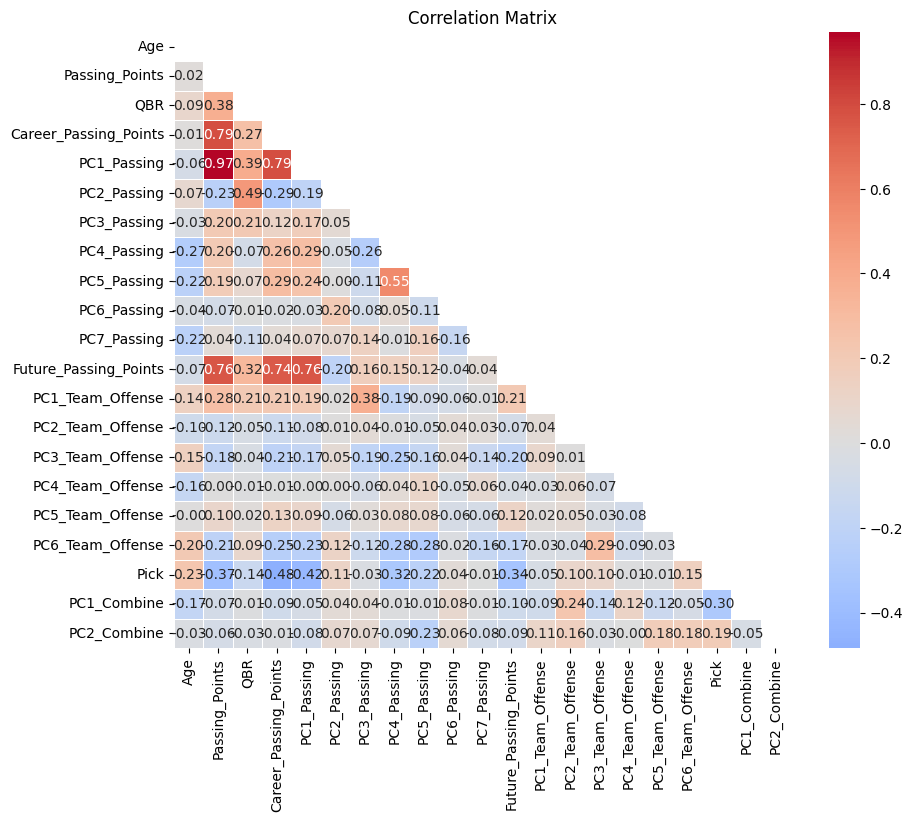

In [129]:
# Correlation Matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('gross_passing_for_ml.csv')
df = df.drop(columns=['Player', 'Tm', 'Pos', 'Year'])

# Compute the correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

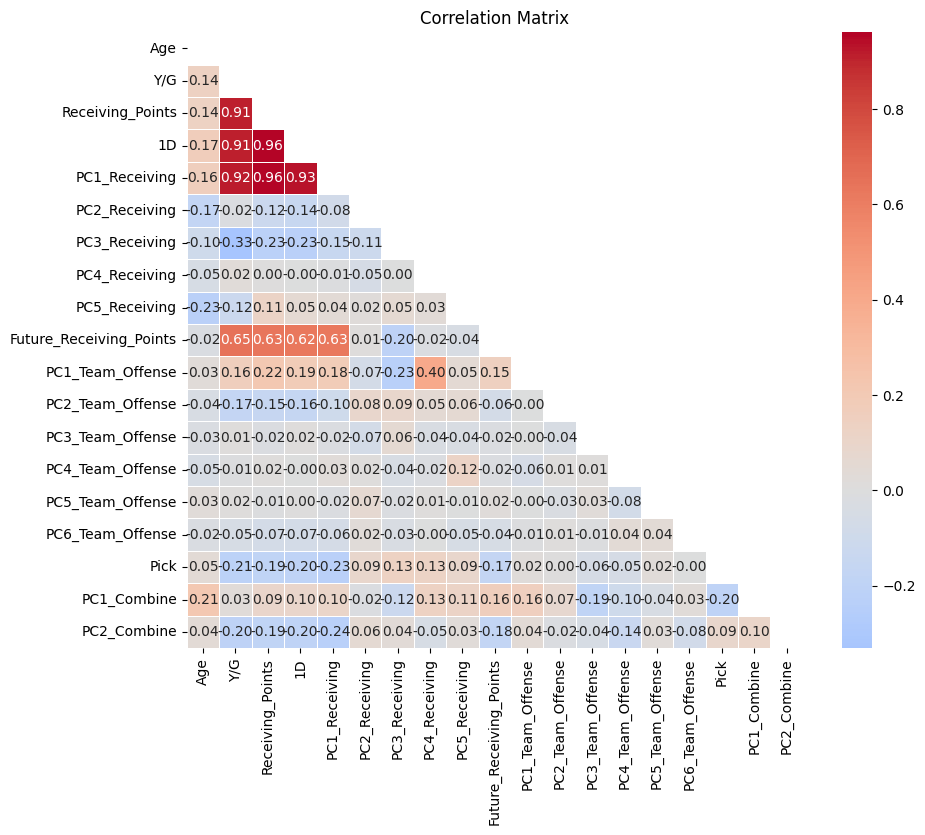

In [130]:
# Correlation Matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('gross_receiving_for_ml.csv')
df = df.drop(columns=['Player', 'Tm', 'Pos', 'Year'])

# Compute the correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()

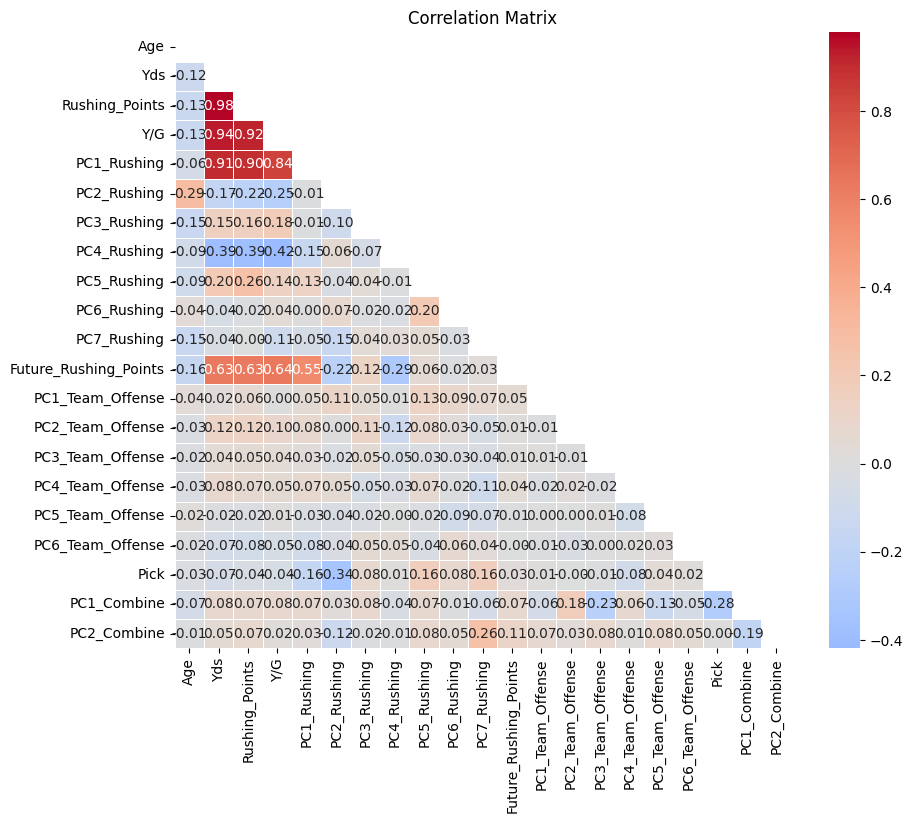

In [131]:
# Correlation Matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load data
df = pd.read_csv('gross_rushing_for_ml.csv')
df = df.drop(columns=['Player', 'Tm', 'Pos', 'Year'])

# Compute the correlation matrix
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))
sns.heatmap(corr, mask=mask, cmap='coolwarm', center=0, annot=True, fmt=".2f", square=True, linewidths=.5)
plt.title('Correlation Matrix')
plt.show()